In [7]:
from pathlib import Path
import re
import pandas as pd
import matplotlib.pyplot as plt

LOG_DIR = Path("./results/concept_logs")  # change if needed
assert LOG_DIR.exists(), f"Log dir not found: {LOG_DIR.resolve()}"

# Regex for your filename pattern:
# train-<train_names>[__test-<test_names>]__<concept>_L<layer>_<seq_type>_M<model_idx>_gpu<gpu>.log
FNAME_RE = re.compile(
    r"^(?P<train_tag>train-.+?)"      # up to next "__"
    r"(?:__test-(?P<test_tag>.+?))?"  # optional, also up to next "__"
    r"__(?P<concept>.+?)"             # up to "_L"
    r"_L(?P<layer>\d+)"
    r"_(?P<seq_type>[A-Za-z]+)"
    r"_M(?P<model_idx>\d+)"
    r"_gpu(?P<gpu>\d+)\.log$"
)

# Regex for the printed result line inside logs
RESULT_RE = re.compile(
    r"we achieve\s+(?P<accuracy>[0-9]*\.?[0-9]+)\s+accuracy,\s+with loss\s+(?P<loss>[0-9]*\.?[0-9]+)",
    re.IGNORECASE
)

import pandas as pd

def average_across_gpus(df: pd.DataFrame) -> pd.DataFrame:
    """
    Return a dataframe with GPU duplicates merged by averaging accuracy (and loss if present).
    - Drops the 'gpu' column.
    - Groups by every other column except ['accuracy','loss','file'].
    - Averages 'accuracy' (and 'loss' if it exists).
    - Collects 'file' names into a list.
    """
    df = df.copy()
    drop_cols = [c for c in ['gpu'] if c in df.columns]
    base_cols = [c for c in df.columns if c not in (set(drop_cols) | {'accuracy', 'loss', 'file'})]

    agg_spec = {}
    if 'accuracy' in df.columns:
        agg_spec['accuracy'] = 'mean'
    if 'loss' in df.columns:
        agg_spec['loss'] = 'mean'
    if 'file' in df.columns:
        agg_spec['file'] = lambda s: list(s)

    out = (
        df.drop(columns=drop_cols, errors='ignore')
          .groupby(base_cols, dropna=False, as_index=False)
          .agg(agg_spec)
          .sort_values(base_cols)
          .reset_index(drop=True)
    )
    return out

In [8]:
from pathlib import Path
import re
import matplotlib.pyplot as plt

def plot_acc_by_layer(
    df,
    train_tag=None,
    test_tag=None,
    out_dir="./results/concept_plots",
    filter_contains=False,
    dpi=120,
):
    """
    Plot accuracy vs. layer, overlaying all experiments that match the given
    (train_tag, test_tag). Each unique (concept, seq_type, model_idx) becomes a line.

    Args:
        df: DataFrame with columns
            ['train_tag','test_tag','concept','layer','seq_type','model_idx','accuracy',...]
        train_tag: str or None — filter by this train tag; None means don't filter.
        test_tag:  str or None — filter by this test tag;  None means don't filter.
        filter_contains: if True, does substring match; else exact match.
        out_dir: where to save the PNG.
        dpi: output DPI for the saved figure.

    Returns:
        The filtered DataFrame used for the plot (or None if empty).
    """
    # ensure results only
    df_valid = df[df["accuracy"].notna()].copy()

    # filtering
    mask = df_valid["accuracy"].notna()
    if train_tag is not None:
        if filter_contains:
            mask &= df_valid["train_tag"].str.contains(re.escape(train_tag))
        else:
            mask &= (df_valid["train_tag"] == train_tag)
    if test_tag is not None:
        if filter_contains:
            mask &= df_valid["test_tag"].str.contains(re.escape(test_tag))
        else:
            mask &= (df_valid["test_tag"] == test_tag)

    sub = df_valid.loc[mask].copy()
    if sub.empty:
        print("No matching rows for the given filters.")
        return None

    # plotting
    Path(out_dir).mkdir(parents=True, exist_ok=True)
    plt.figure()

    for (concept, seq_type, model_idx), grp in sub.groupby(["concept", "seq_type", "model_idx"]):
        grp = grp.sort_values("layer")
        plt.plot(grp["layer"], grp["accuracy"], marker="o",
                 label=f"{concept.replace('_',' ')} | {seq_type} | M{model_idx}")

    plt.xlabel("Layer")
    plt.ylabel("Accuracy")
    tt = test_tag if (test_tag not in [None, ""]) else "∅"
    tr = train_tag if (train_tag not in [None, ""]) else "∅"
    plt.title(f"train={tr} | test={tt}")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.)

    # save
    def sanitize(s): return str(s).replace("/", "_").replace(" ", "_")
    fname = f"acc_by_layer__train-{sanitize(tr)}__test-{sanitize(tt)}.png"
    out_path = Path(out_dir) / fname
    plt.savefig(out_path, bbox_inches="tight", dpi=dpi)
    plt.show()

    return sub

In [10]:
rows = []
for log_path in LOG_DIR.glob("*.log"):
    m = FNAME_RE.match(log_path.name)
    if not m:
        # skip unexpected file names
        continue

    meta = m.groupdict()
    # Try to read accuracy/loss from the *last* matching line in the log
    acc = loss = None
    try:
        text = log_path.read_text(errors="ignore")
        matches = list(RESULT_RE.finditer(text))
        if matches:
            acc = float(matches[-1].group("accuracy"))
            loss = float(matches[-1].group("loss"))
    except Exception as e:
        # unreadable file? leave acc/loss as None
        pass

    rows.append({
        "file": log_path,
        "train_tag": meta["train_tag"],                # e.g., train-fischer_random+sts
        "test_tag":  meta.get("test_tag") or "",       # e.g., fischer_random+sts or ""
        "concept":   meta["concept"],                  # sanitized name (underscores)
        "layer":     int(meta["layer"]),
        "seq_type":  meta["seq_type"],
        "model_idx": int(meta["model_idx"]),
        "gpu":       int(meta["gpu"]),
        "accuracy":  acc,
        "loss":      loss,
    })

df = pd.DataFrame(rows).sort_values(["concept", "seq_type", "model_idx", "layer"]).reset_index(drop=True)
print(f"Parsed {len(df)} logs (non-empty results: {(df['accuracy'].notna()).sum()})")

df = average_across_gpus(df)
df.head(10)

Parsed 1009 logs (non-empty results: 833)


,train_tag,test_tag,concept,layer,seq_type,model_idx,accuracy,loss,file
0,train-fischer_random,,Advancement_of_a_b_c_Pawns,2,activations,0,0.722222,0.668960,[results\concept_logs\train-fischer_random__Ad...
1,train-fischer_random,,Advancement_of_a_b_c_Pawns,2,activations,1,0.742063,3.395316,[results\concept_logs\train-fischer_random__Ad...
2,train-fischer_random,,Advancement_of_a_b_c_Pawns,2,activations,2,0.609788,0.187095,[results\concept_logs\train-fischer_random__Ad...
3,train-fischer_random,,Advancement_of_a_b_c_Pawns,5,activations,0,0.634259,2.107608,[results\concept_logs\train-fischer_random__Ad...
4,train-fischer_random,,Advancement_of_a_b_c_Pawns,5,activations,1,0.685185,18.137867,[results\concept_logs\train-fischer_random__Ad...
5,train-fischer_random,,Advancement_of_a_b_c_Pawns,5,activations,2,0.579365,1.369819,[results\concept_logs\train-fischer_random__Ad...
6,train-fischer_random,,Advancement_of_a_b_c_Pawns,10,activations,0,0.496032,3.255707,[results\concept_logs\train-fischer_random__Ad...
7,train-fischer_random,,Advancement_of_a_b_c_Pawns,10,activations,1,0.593915,59.293007,[results\concept_logs\train-fischer_random__Ad...
8,train-fischer_random,,Advancement_of_a_b_c_Pawns,10,activations,2,0.530754,2.616888,[results\concept_logs\train-fischer_random__Ad...
9,train-fischer_random,,Advancement_of_a_b_c_Pawns,15,activations,0,0.496032,3.609640,[results\concept_logs\train-fischer_random__Ad...


In [11]:
df["train_tag"] = df["train_tag"].str.replace(r"^train-", "", regex=True)
df["test_tag"]  = df["test_tag"].str.replace(r"^test-",  "", regex=True)  # harmless if already clean

# (Optional) also keep list versions if you want to group by the set of train/test datasets
df["train_list"] = df["train_tag"].str.split("+").apply(lambda x: [t for t in x if t] if isinstance(x, list) else [])
df["test_list"]  = df["test_tag"].str.split("+").apply(lambda x: [t for t in x if t] if isinstance(x, list) else [])

# Reorder to peek
df.sort_values(["train_tag", "test_tag", "concept", "model_idx", "layer"]).head(10)

,train_tag,test_tag,concept,layer,seq_type,model_idx,accuracy,loss,file,train_list,test_list
0,fischer_random,,Advancement_of_a_b_c_Pawns,2,activations,0,0.722222,0.668960,[results\concept_logs\train-fischer_random__Ad...,[fischer_random],[]
3,fischer_random,,Advancement_of_a_b_c_Pawns,5,activations,0,0.634259,2.107608,[results\concept_logs\train-fischer_random__Ad...,[fischer_random],[]
6,fischer_random,,Advancement_of_a_b_c_Pawns,10,activations,0,0.496032,3.255707,[results\concept_logs\train-fischer_random__Ad...,[fischer_random],[]
9,fischer_random,,Advancement_of_a_b_c_Pawns,15,activations,0,0.496032,3.609640,[results\concept_logs\train-fischer_random__Ad...,[fischer_random],[]
1,fischer_random,,Advancement_of_a_b_c_Pawns,2,activations,1,0.742063,3.395316,[results\concept_logs\train-fischer_random__Ad...,[fischer_random],[]
4,fischer_random,,Advancement_of_a_b_c_Pawns,5,activations,1,0.685185,18.137867,[results\concept_logs\train-fischer_random__Ad...,[fischer_random],[]
7,fischer_random,,Advancement_of_a_b_c_Pawns,10,activations,1,0.593915,59.293007,[results\concept_logs\train-fischer_random__Ad...,[fischer_random],[]
10,fischer_random,,Advancement_of_a_b_c_Pawns,15,activations,1,0.533069,110.796151,[results\concept_logs\train-fischer_random__Ad...,[fischer_random],[]
2,fischer_random,,Advancement_of_a_b_c_Pawns,2,activations,2,0.609788,0.187095,[results\concept_logs\train-fischer_random__Ad...,[fischer_random],[]
5,fischer_random,,Advancement_of_a_b_c_Pawns,5,activations,2,0.579365,1.369819,[results\concept_logs\train-fischer_random__Ad...,[fischer_random],[]


In [12]:
# Cell 3 — Best-performing layer per setup
# Define the setup keys: everything except 'layer' and the metric fields
SETUP_KEYS = ["train_tag", "test_tag", "concept", "seq_type", "model_idx"]

# Drop rows with no accuracy
df_valid = df.dropna(subset=["accuracy"]).copy()

# For each setup, pick the row with the max accuracy
idx = df_valid.groupby(SETUP_KEYS)["accuracy"].idxmax()
best_per_setup = df_valid.loc[idx].sort_values(SETUP_KEYS + ["layer"])

# Optional: prettify the concept by turning underscores back to spaces
best_per_setup["concept_pretty"] = best_per_setup["concept"].str.replace("_", " ")

# Show the essentials
cols_to_show = SETUP_KEYS + ["layer", "accuracy", "loss", "file"]
best_per_setup_display = best_per_setup[cols_to_show].reset_index(drop=True)
best_per_setup_display[:100]

best_per_setup_display[(best_per_setup_display['train_tag'] == 'fischer_random+sts') & (best_per_setup_display['test_tag'] == 'fischer_random')]


,train_tag,test_tag,concept,seq_type,model_idx,layer,accuracy,loss,file
90,fischer_random+sts,fischer_random,Advancement_of_a_b_c_Pawns,activations,0,5,0.753472,1.177220,[results\concept_logs\train-fischer_random+sts...
91,fischer_random+sts,fischer_random,Advancement_of_a_b_c_Pawns,activations,1,2,0.798611,2.973274,[results\concept_logs\train-fischer_random+sts...
92,fischer_random+sts,fischer_random,Advancement_of_a_b_c_Pawns,activations,2,2,0.657986,0.123158,[results\concept_logs\train-fischer_random+sts...
93,fischer_random+sts,fischer_random,Advancement_of_f_g_h_Pawns,activations,0,5,0.732456,1.667336,[results\concept_logs\train-fischer_random+sts...
94,fischer_random+sts,fischer_random,Advancement_of_f_g_h_Pawns,activations,1,2,0.783626,3.415023,[results\concept_logs\train-fischer_random+sts...
95,fischer_random+sts,fischer_random,Advancement_of_f_g_h_Pawns,activations,2,5,0.584795,1.558507,[results\concept_logs\train-fischer_random+sts...
96,fischer_random+sts,fischer_random,Advancement_of_f_g_h_pawns,activations,0,2,0.583333,0.842622,[results\concept_logs\train-fischer_random+sts...
97,fischer_random+sts,fischer_random,Advancement_of_f_g_h_pawns,activations,1,2,0.672515,4.572601,[results\concept_logs\train-fischer_random+sts...
98,fischer_random+sts,fischer_random,Advancement_of_f_g_h_pawns,activations,2,15,0.513158,3.501594,[results\concept_logs\train-fischer_random+sts...
99,fischer_random+sts,fischer_random,Center_Control,activations,0,5,0.679012,2.327601,[results\concept_logs\train-fischer_random+sts...


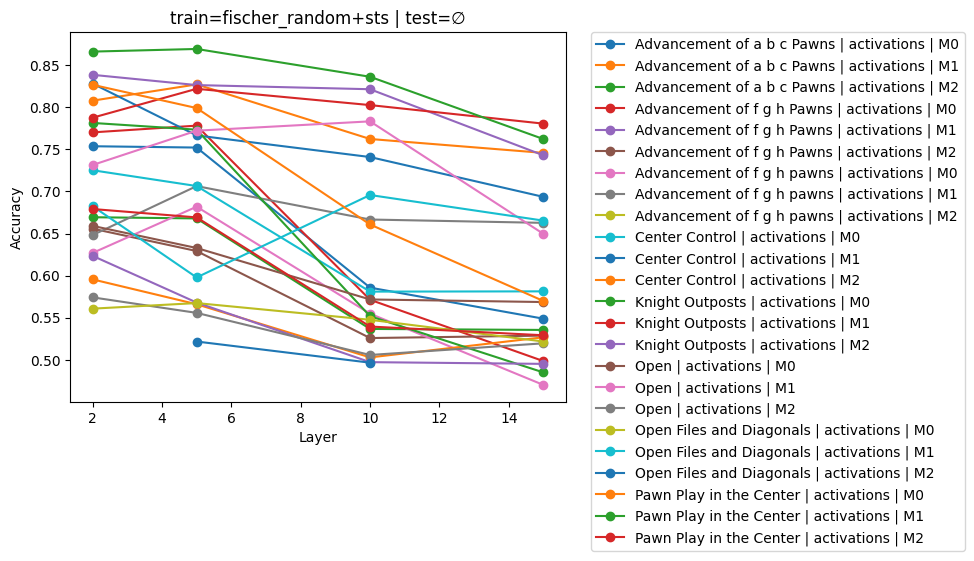

,train_tag,test_tag,concept,layer,seq_type,model_idx,accuracy,loss,file,train_list,test_list
278,fischer_random+sts,,Advancement_of_a_b_c_Pawns,2,activations,0,0.753674,0.354742,[results\concept_logs\train-fischer_random+sts...,"[fischer_random, sts]",[]
279,fischer_random+sts,,Advancement_of_a_b_c_Pawns,2,activations,1,0.807770,2.918479,[results\concept_logs\train-fischer_random+sts...,"[fischer_random, sts]",[]
280,fischer_random+sts,,Advancement_of_a_b_c_Pawns,2,activations,2,0.669384,0.111690,[results\concept_logs\train-fischer_random+sts...,"[fischer_random, sts]",[]
281,fischer_random+sts,,Advancement_of_a_b_c_Pawns,5,activations,0,0.752114,1.303630,[results\concept_logs\train-fischer_random+sts...,"[fischer_random, sts]",[]
282,fischer_random+sts,,Advancement_of_a_b_c_Pawns,5,activations,1,0.827093,11.083823,[results\concept_logs\train-fischer_random+sts...,"[fischer_random, sts]",[]
...,...,...,...,...,...,...,...,...,...,...,...
366,fischer_random+sts,,Pawn_Play_in_the_Center,10,activations,1,0.836151,23.763486,[results\concept_logs\train-fischer_random+sts...,"[fischer_random, sts]",[]
367,fischer_random+sts,,Pawn_Play_in_the_Center,10,activations,2,0.539603,2.256131,[results\concept_logs\train-fischer_random+sts...,"[fischer_random, sts]",[]
368,fischer_random+sts,,Pawn_Play_in_the_Center,15,activations,0,0.569897,2.611800,[results\concept_logs\train-fischer_random+sts...,"[fischer_random, sts]",[]
369,fischer_random+sts,,Pawn_Play_in_the_Center,15,activations,1,0.762178,53.761551,[results\concept_logs\train-fischer_random+sts...,"[fischer_random, sts]",[]


In [17]:
plot_acc_by_layer(df, train_tag='fischer_random+sts', test_tag='')


In [ ]:
plot_acc_by_layer(df, train_tag='sts', test_tag='')